### last updated 3/28/2020
+ It is a very simple model to track the progress of Covid in major countries and estimate if the exponential (explosive) spread of the virus is slowing down 
+ I fit the data to an exponential function N=I x exp(Ke*days). And by looking at the data fit of (1) all data; (2) the most recent 5-7 day data; (3) and setdiff([1],[2]) and examining how Ke (the constant in the exponent) changes, we can compare the "explosiveness" of the spread in different regions (the higher Ke, the faster the spread) and estimate if the spread is slowing down (significant drop in Ke)
+ 3/28: I added a "range" of estimate to account for change in the rate of growth based on last 7 days of data. This is kind of ad-hoc, mostly used to highlight the uncertainty in the prediction. A very tight range indicates the trend is a very good exponential fitting and the prediction is likely to be accurate.
+ 3/28: I also added the data for a few large states in the US

###  Observations as of 3/28: 
#### China
+ Rapid spread happened around Jan-22 - Feb05 (for about 2 weeks) with Ke=0.197. The turning point occured around Feb05 with Ke drop to around 0.075 in the 7 day after. The predicted number for Feb-18 (~77k) slightly overshoot the acutal number (~74k).

#### Italy: 
+ Rapid spread happened around Feb-23 - Mar21 (about 4 weeks) with Ke=0.149. It suggests Italy was 1 month behind China and spread slower. On Mar21, 7-day trailing Ke dropped to around 0.078. On Mar22, 7-day trailing Ke dropped to around 0.066.It sugguests the worst is likely over for Italy. Predicted number is around 150k cases in a week.

#### Spain: 
+ Rapid spread started around  Mar-09 and is ongoing. Ke is about 0.166, about the same as Italy. There is a slight drop to 0.142, indicating the explosive spreading is likely to persist for quite a few more weeks

#### US:
+ US is unquestionably the worst. Rapid spread started around the same time as in Spain (6 weeks behind China and 2 weeks behind Italy). Ke =0.317 was the highest. The most recent 7 day Ke is 0.199, dropped from 0.219 on yesterday. This mostly due to NY data and is very explosive - comparable to the worst in China and worse than worst time in Italy It suggests there is likely quite a few weeks of rapid growth in US left. And we may see numbers above 400K in a week.

#### US New York:
+ NY has been hitting very hard with the mostly explosive days saw Ke>0.4. The most recent 7-day trailing Ke is now 0.167, still bad but much improved. It is now compatible to (and slightly better than) the rest of US

#### US other states:
+ all other states areall going through perfect exponential spread (with slightly varying explosive), indicating we will see many dark days ahead. Simply put, THIS IS GOING TO BE BAD.
+ California' Ke is about 0.19, which has been very consistent. IT IS GOING TO BE BAD.
+ Texas sees slight higher Ke at about 0.22, worse than california. IT IS GOING TO BE BAD.
+ Massachusetts' Ke has gone up from about 0.2 to about 0.3. IT IS GOING TO BE VERY BAD in MA.

#### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

#### Define the fitting function, which is a simple expoential function -- what really matters is the exponent constant

In [2]:
def func(x, I0, k):     # a = I0, b = k
  return I0 * np.exp(k*(x-x[0]))    
  #return I0 * np.exp(k*x)    

#### Setup Analysis parameters, Import the data and seperate into more recent and "old" ones

In [3]:
start={
       "China" : "2020-01-22",
       "Spain" : "2020-03-01",
       "Italy" : "2020-02-22",
       "US-ALL": "2020-03-01",
       "US-NY": "2020-03-01", 
       "US-CA": "2020-03-01",
       "US-WA": "2020-03-01",
       "US-MA": "2020-03-01",
       "US-TX": "2020-03-01"
}
Nback  = 7-2 # use a number of days to check if trend has changed
Nfwd   = 7

# import and print out data
df = pd.read_csv('data.csv',delim_whitespace=True, parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
dNow   = datetime.now() - timedelta(days=1)            # today
print ('Tablulated Positive Covid-19 Cases for countries of interest')
display(HTML(df.loc[df['Date']<dNow,:].to_html(index=False,float_format="%d",border=2)))

Tablulated Positive Covid-19 Cases for countries of interest


Date,China,Italy,Spain,US-ALL,US-NY,US-CA,US-WA,US-MA,US-TX
2020-01-22,571,0,0,0,0,0,0,0,0
2020-01-23,830,0,0,0,0,0,0,0,0
2020-01-24,1287,0,0,0,0,0,0,0,0
2020-01-25,1975,0,0,0,0,0,0,0,0
2020-01-26,2744,0,0,0,0,0,0,0,0
2020-01-27,4515,0,0,0,0,0,0,0,0
2020-01-28,5974,0,0,0,0,0,0,0,0
2020-01-29,7711,0,0,0,0,0,0,0,0
2020-01-30,9692,0,0,0,0,0,0,0,0
2020-01-31,11791,0,0,0,0,0,0,0,0


#### function to analyze one country's data 

In [4]:
def analyze_case(country):
    # seperate into different segment
    if country=="China": 
        dEnd = pd.to_datetime("2020-02-12")  # china starts early and ends early
    else:
        dEnd = dNow
    dTurn1 = dEnd - timedelta(days=Nback+1)      # go bkwd to seperate old from recent 
    dTurn2 = dEnd - timedelta(days=Nback+2)
    dFwd   = dEnd + timedelta(days=Nfwd-1)       # go a few days fwd for prediction
    dStart = pd.to_datetime(start[country])                   # each country start to have cases accelerating at differnt time
    
    df0 = df.loc[(df.Date>dStart)  & (df.Date<dEnd) ,:]       # all data to be analyzed
    df1 = df.loc[(df.Date>dStart)  & (df.Date<dTurn1) ,:]     # "old" data
    df2 = df.loc[(df.Date>=dTurn2) & (df.Date<dEnd),:]       # recent data
    df3 = df.loc[(df.Date>dStart)  & (df.Date<dFwd) ,:]      # forcast
    my_xticks = df3["Date"].dt.strftime("%b%d")
    
    # optimal data fitting for each segment
    y0 = df0[country]
    y1 = df1[country]
    y2 = df2[country]
    x0 = np.arange(1,len(y0)+1)
    x1 = np.arange(1,len(y1)+1)
    x2 = np.arange(len(y0)-len(y2)+1,len(y0)+1)
    x3 = np.arange(len(y0),len(y0)+Nfwd+1)
    popt0, pcov = curve_fit(func, x0, y0)
    popt1, pcov = curve_fit(func, x1, y1)
    popt2, pcov = curve_fit(func, x2, y2)
    
    # plot results    
    fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x0, func(x0, *popt0), 'b--', label="all fit")  
    plt.plot(x1, y1, 'bo',label="past data")
    plt.plot(x1, func(x1, *popt1), 'b', label="past fit")  
    plt.plot(x2, y2, 'md',label="recent data")
    v2 = func(x2, *popt2)
    plt.plot(x2, v2, 'm', label="recent fit") 
    vF1 = func(x3, *popt2)
    vF1 *= v2[-1]/vF1[0]
    plt.plot(x3[1:], vF1[1:], 'rv--', label="Forcast Based on Latest Fit ") 
    # popt2[1] -=  np.max((popt0[1]-popt2[1]),0)*7.0/len(x1)
    popt2[1] -=  (popt1[1]-popt2[1])/3.
    vF2 = func(x3, *popt2)
    vF2 *= v2[-1]/vF2[0]
    plt.plot(x3[1:],vF2[1:], 'r^--', label="Forcast Based on Adjusted Fit") 
    plt.xticks(np.append(x0,x3),my_xticks, rotation='vertical')
    #plt.xticks(x2, my_xticks2, rotation='vertical')
    plt.ylabel('# of cases')
    #plt.title(r'$N = '+f'{popt[0]:.3f}'+'*exp^{('+f'{popt[1]:.3f}'+'*days)}$')
    plt.title(country +r': $N_{all} = I_{all}'+'*e^{('+f'{popt0[1]:.3f}'+'*days)}$;  ' + r'$N_{past} = I_{past}'+'*e^{('+f'{popt1[1]:.3f}'+'*days)}$' + r';   $N_{latest} = I_{latest}'+'*e^{('+f'{popt2[1]:.3f}'+'*days)}$',fontsize=16, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()
    
    # print out summary of results
    print ("Exponent Values:")
    print ("  all data     = %.3f" % popt0[1])
    print ("  old data     = %.3f" % popt1[1]) 
    print ("  recent data  = %.3f" % popt2[1])
    print ("predicted cases at the end of next %d days is [%.1f-%.1f]k" % (Nfwd,vF2[-1]/1000,vF1[-1]/1000))

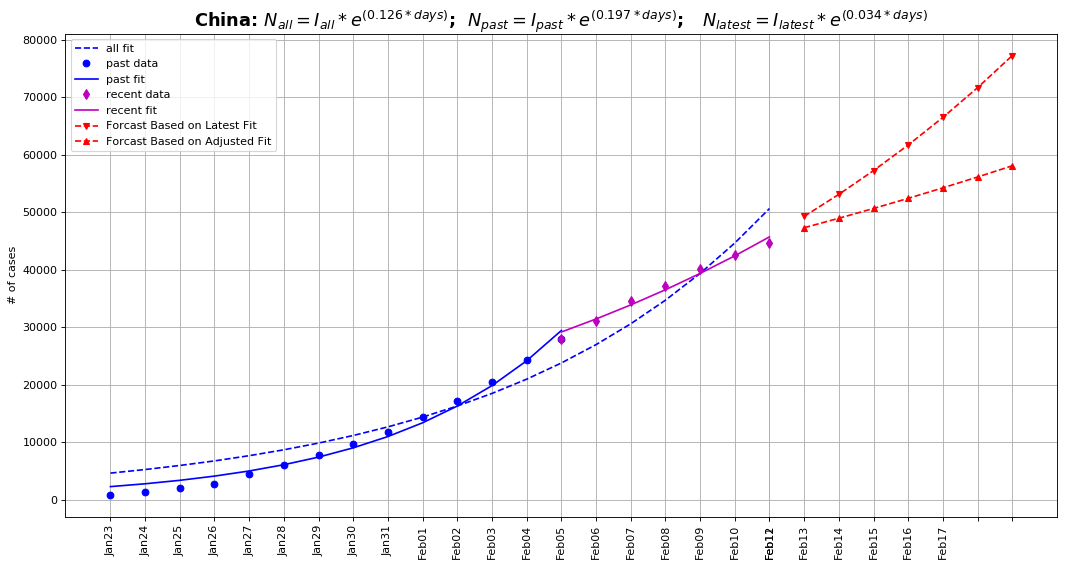

Exponent Values:
  all data     = 0.126
  old data     = 0.197
  recent data  = 0.034
predicted cases at the end of next 7 days is [58.1-77.2]k


In [5]:
analyze_case("China")

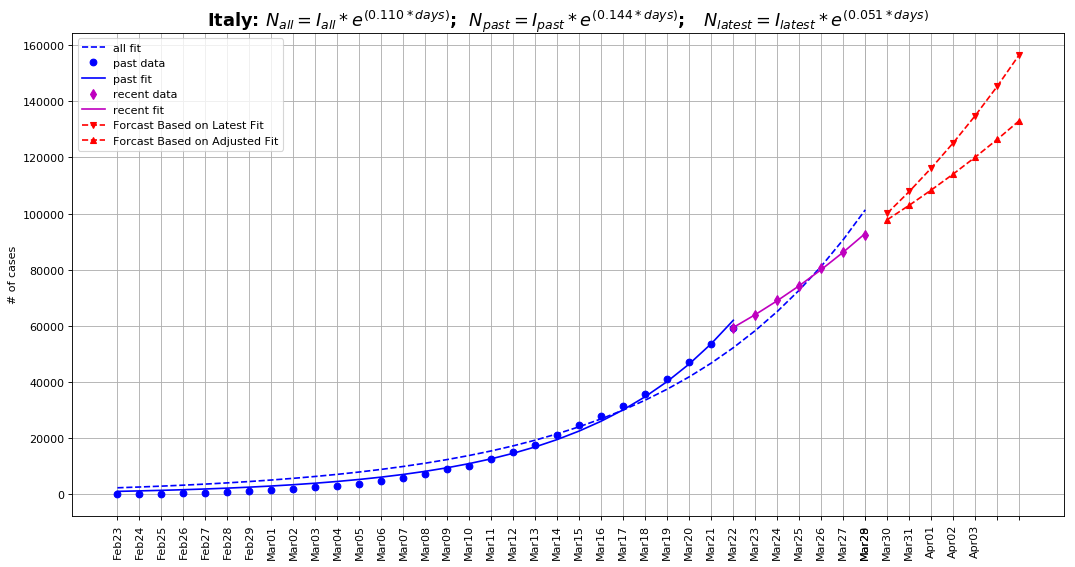

Exponent Values:
  all data     = 0.110
  old data     = 0.144
  recent data  = 0.051
predicted cases at the end of next 7 days is [133.1-156.6]k


In [6]:
analyze_case("Italy")

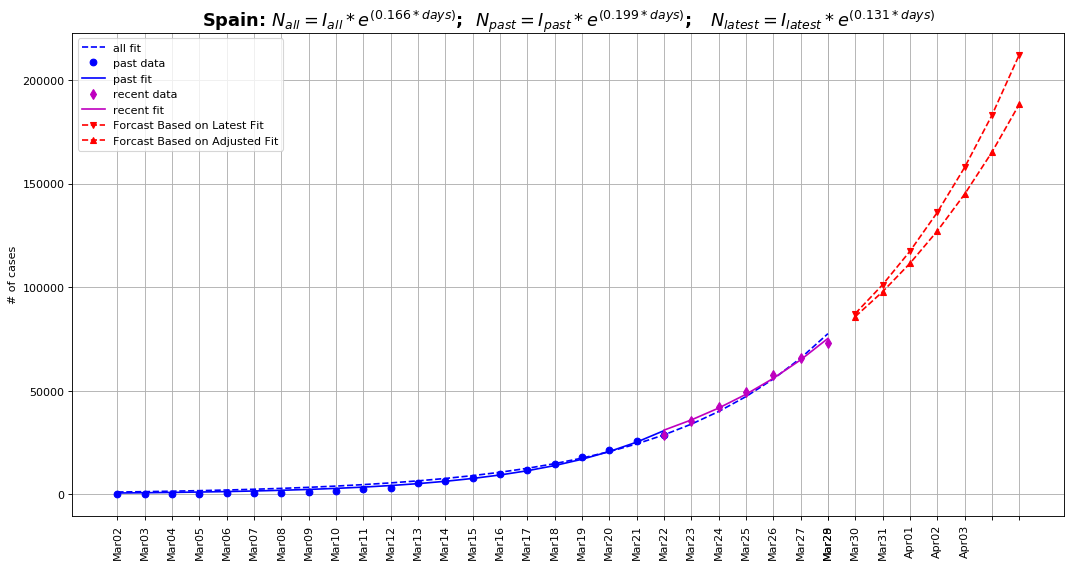

Exponent Values:
  all data     = 0.166
  old data     = 0.199
  recent data  = 0.131
predicted cases at the end of next 7 days is [188.3-212.2]k


In [7]:
analyze_case("Spain")

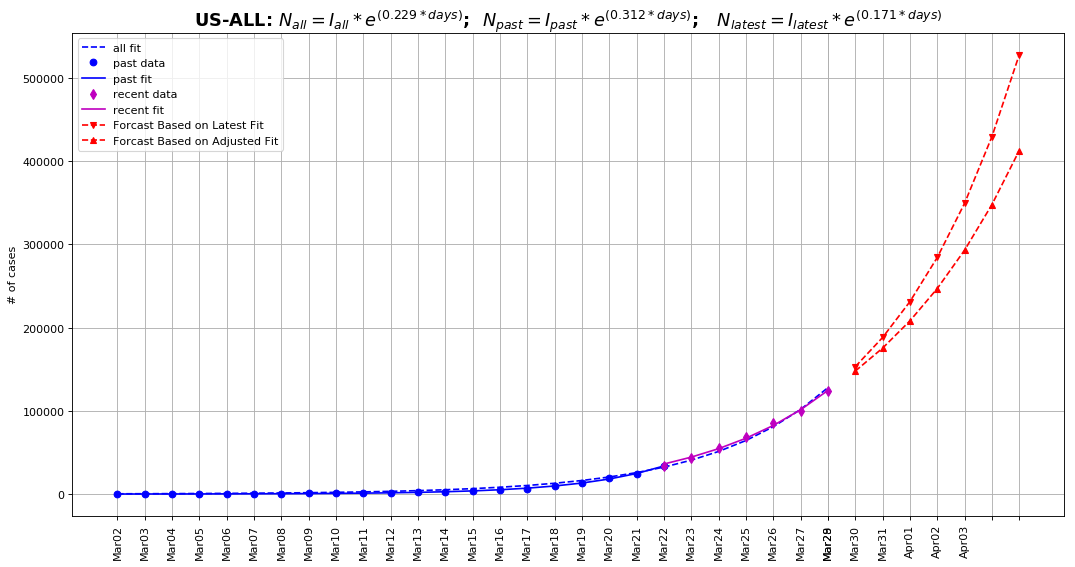

Exponent Values:
  all data     = 0.229
  old data     = 0.312
  recent data  = 0.171
predicted cases at the end of next 7 days is [412.8-528.0]k


In [8]:
analyze_case("US-ALL")

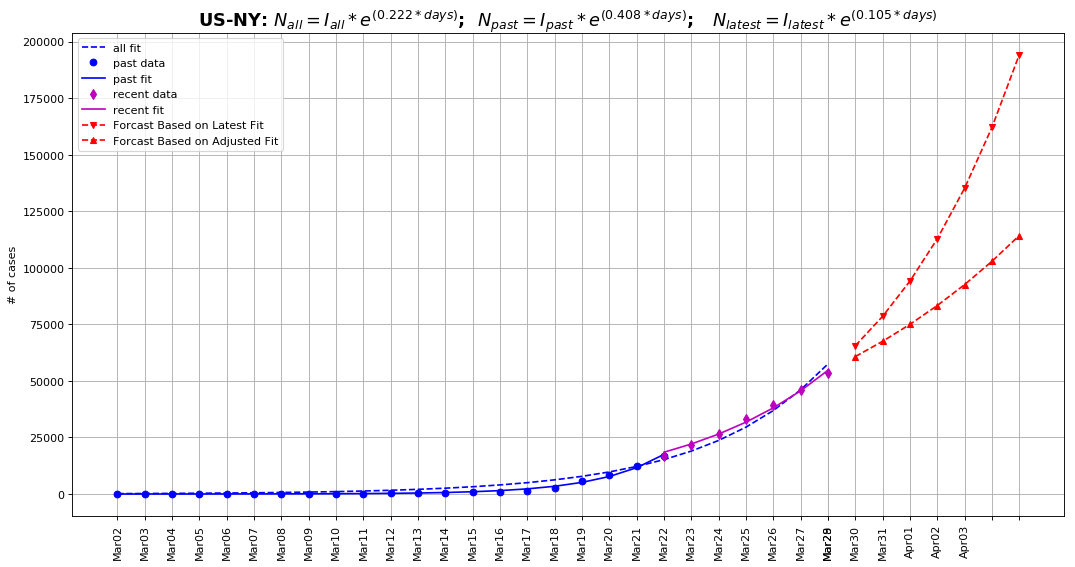

Exponent Values:
  all data     = 0.222
  old data     = 0.408
  recent data  = 0.105
predicted cases at the end of next 7 days is [114.3-194.2]k


In [9]:
analyze_case("US-NY")

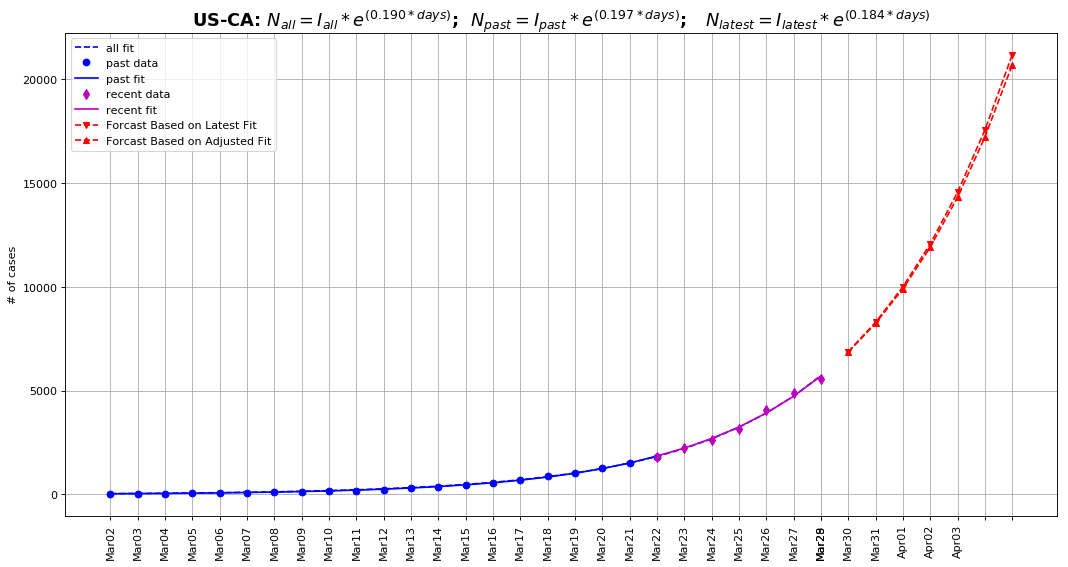

Exponent Values:
  all data     = 0.190
  old data     = 0.197
  recent data  = 0.184
predicted cases at the end of next 7 days is [20.7-21.2]k


In [10]:
analyze_case("US-CA")

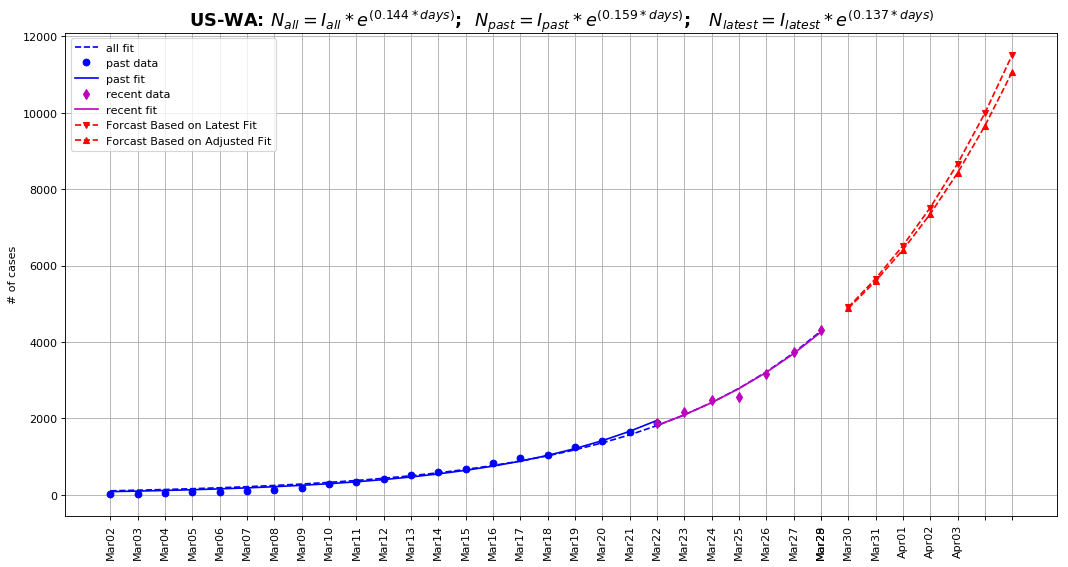

Exponent Values:
  all data     = 0.144
  old data     = 0.159
  recent data  = 0.137
predicted cases at the end of next 7 days is [11.1-11.5]k


In [11]:
analyze_case("US-WA")

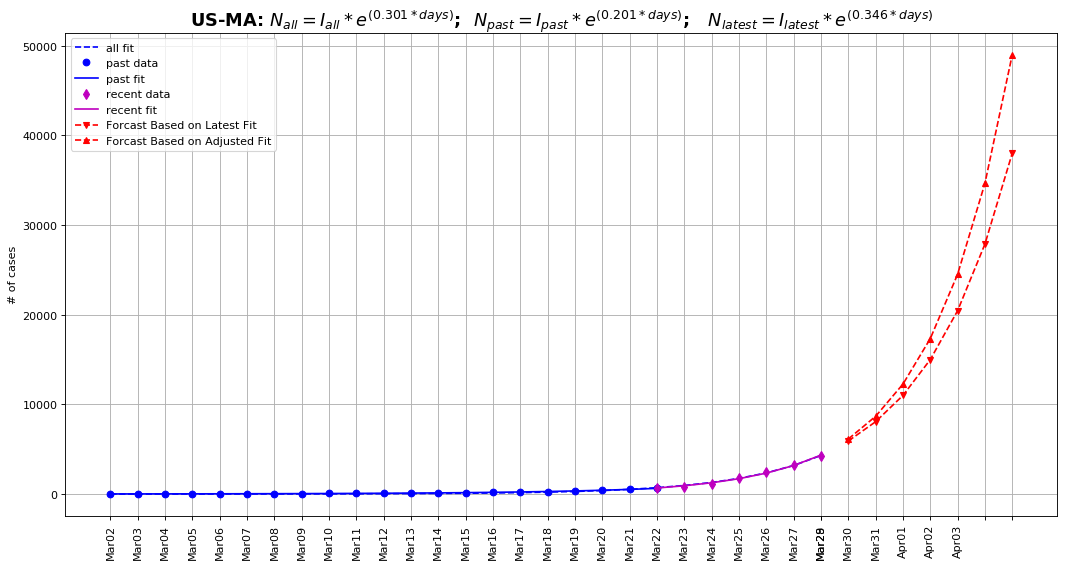

Exponent Values:
  all data     = 0.301
  old data     = 0.201
  recent data  = 0.346
predicted cases at the end of next 7 days is [49.0-38.0]k


In [12]:
analyze_case("US-MA")

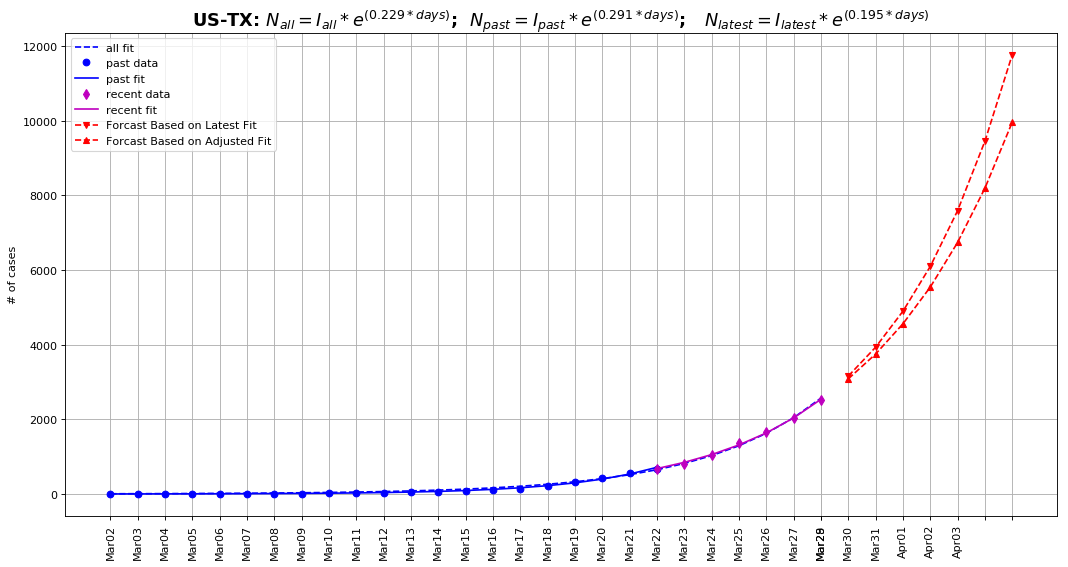

Exponent Values:
  all data     = 0.229
  old data     = 0.291
  recent data  = 0.195
predicted cases at the end of next 7 days is [10.0-11.8]k


In [13]:
analyze_case("US-TX")